In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from sklearn.model_selection import train_test_split
from tabulate import tabulate

## Prepare train and test data sets

Prepare dataframes of the file paths for the train, test and validation data sets

In [4]:
dir_path = "./data/"
file_paths = []
labels = []
folders = os.listdir(dir_path)

In [5]:
for folder in folders:
    fold_path = dir_path + folder
    for file in os.listdir(fold_path):
        file_paths.append(fold_path + "/" + file)
        labels.append(folder)

In [6]:
df = pd.DataFrame({"file_path": file_paths, "label": labels}).sample(frac=1)
df.head()

,file_path,label
10068,./data/Parasitized/C60P21thinF_IMG_20150804_10...,Parasitized
15575,./data/Uninfected/C178P139NThinF_IMG_20151201_...,Uninfected
18400,./data/Uninfected/C84P45ThinF_IMG_20150818_101...,Uninfected
16510,./data/Uninfected/C72P33_ThinF_IMG_20150815_10...,Uninfected
24771,./data/Uninfected/C126P87ThinF_IMG_20151004_10...,Uninfected


In [7]:
df.describe()

,file_path,label
count,27560,27560
unique,27560,2
top,./data/Parasitized/C132P93ThinF_IMG_20151004_1...,Parasitized
freq,1,13780


In [8]:
df.reset_index(inplace=True, drop=True)
df.head(5)

,file_path,label
0,./data/Parasitized/C60P21thinF_IMG_20150804_10...,Parasitized
1,./data/Uninfected/C178P139NThinF_IMG_20151201_...,Uninfected
2,./data/Uninfected/C84P45ThinF_IMG_20150818_101...,Uninfected
3,./data/Uninfected/C72P33_ThinF_IMG_20150815_10...,Uninfected
4,./data/Uninfected/C126P87ThinF_IMG_20151004_10...,Uninfected


In [9]:
train_df, tv_df = train_test_split(df, test_size=0.2, shuffle=True)

In [10]:
valid_df, test_df = train_test_split(tv_df, test_size=0.5, shuffle=True)

In [11]:
# Get the size of the DataFrames
print(tabulate([["train_df", len(train_df)], ["test_df", len(test_df)], ["valid_df", len(valid_df)]], headers=["df", "no of samples"]))
print(f"The total number of detected file paths is: {len(df)}")

df          no of samples
--------  ---------------
train_df            22048
test_df              2756
valid_df             2756
The total number of detected file paths is: 27560


### Plot some of the images

Get a feel of the dataset haha

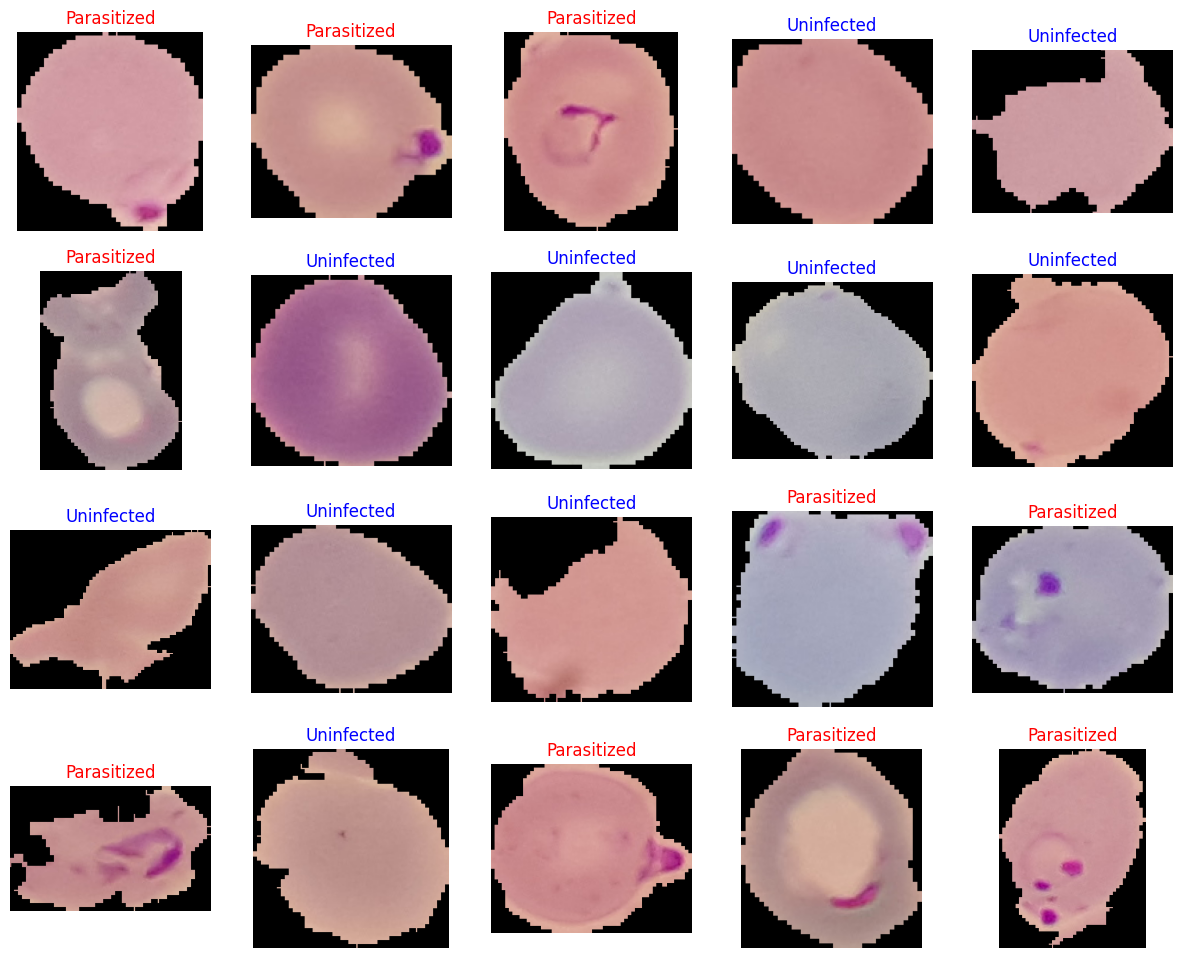

In [12]:
plt.figure(figsize=(15, 15))
for i in range(20):
    plt.subplot(5, 5, i+1)
    sample = train_df.sample().iloc[0]
    file_path = sample.file_path
    label = sample.label
    plt.imshow(image.load_img(file_path))
    color = "blue" if label=="Uninfected" else "red"
    plt.title(label, color=color, fontsize= 12)
    plt.axis('off')

## Train the model

In [13]:
# Get the number of classes - should be 2 (parasitized and uninfected)
K = df.label.nunique()
K

2

In [14]:
IMG_SIZE = (224, 224)
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
TRAIN_VALID_BATCH_SIZE = 64
ts_length = len(test_df)
TEST_BATCH_SIZE = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

In [15]:
gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [16]:
train_gen = gen.flow_from_dataframe(
    train_df,
    x_col="file_path",
    y_col="label",
    shuffle=True,
    target_size=IMG_SIZE,
    batch_size=TRAIN_VALID_BATCH_SIZE
)

Found 22047 validated image filenames belonging to 2 classes.


In [17]:
test_gen = gen.flow_from_dataframe(
    test_df,
    x_col="file_path",
    y_col="label",
    shuffle=False,
    target_size=IMG_SIZE,
    batch_size=TEST_BATCH_SIZE
)

Found 2756 validated image filenames belonging to 2 classes.


In [18]:
valid_gen = gen.flow_from_dataframe(
    valid_df,
    x_col="file_path",
    y_col="label",
    shuffle=True,
    target_size=IMG_SIZE,
    batch_size=TRAIN_VALID_BATCH_SIZE
)

Found 2755 validated image filenames belonging to 2 classes.


In [21]:
base_model = InceptionV3(
    input_shape=IMG_SHAPE,
    weights="imagenet",
    include_top=False
)

In [22]:
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [23]:
base_model.trainable = False

In [24]:
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation="relu"),
    Dropout(0.2),
    Flatten(),
    Dense(K, activation="softmax")
])

In [25]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [26]:
epochs = 15
r = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    shuffle=False
)

Epoch 1/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - accuracy: 0.8558 - loss: 0.4798 - val_accuracy: 0.9071 - val_loss: 0.2840
Epoch 2/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.9064 - loss: 0.2909 - val_accuracy: 0.9172 - val_loss: 0.2252
Epoch 3/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.9087 - loss: 0.2485 - val_accuracy: 0.9256 - val_loss: 0.2203
Epoch 4/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 498s 1s/step - accuracy: 0.9229 - loss: 0.2092 - val_accuracy: 0.9198 - val_loss: 0.2086
Epoch 5/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.9250 - loss: 0.1978 - val_accuracy: 0.9285 - val_loss: 0.2123
Epoch 6/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 498s 1s/step - accuracy: 0.9280 - loss: 0.1995 - val_accuracy: 0.9256 - val_loss: 0.1932
Epoch 7/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 496s 1s/step - accuracy: 0.9277 - loss: 0.2000 - val_accuracy: 0.9358 - val_loss: 0.1923
Epoch 8/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.9292 - loss: 0.1929 - val_accu

## Model Evaluation

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_188         │ (None, 5, 5, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5, 5, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │        12,802 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,431,208 (89.38 MB)

 Trainable params: 541,442 (2.07 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

 Optimizer params: 1,082,886 (4.13 MB)

In [29]:
tr_acc = r.history['accuracy']
tr_loss = r.history['loss']
val_acc = r.history['val_accuracy']
val_loss = r.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

#### Plot train history

In [30]:
plt.style.use('fivethirtyeight')

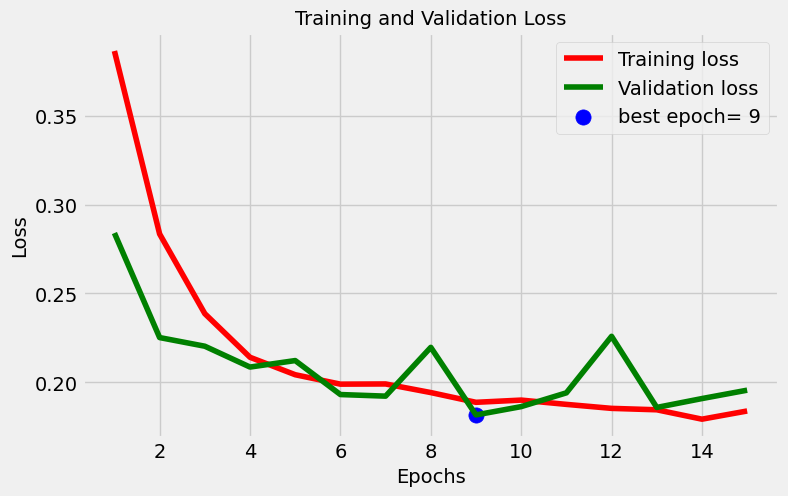

In [31]:
plt.figure(figsize= (8, 5))
plt.plot(epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 120, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend();

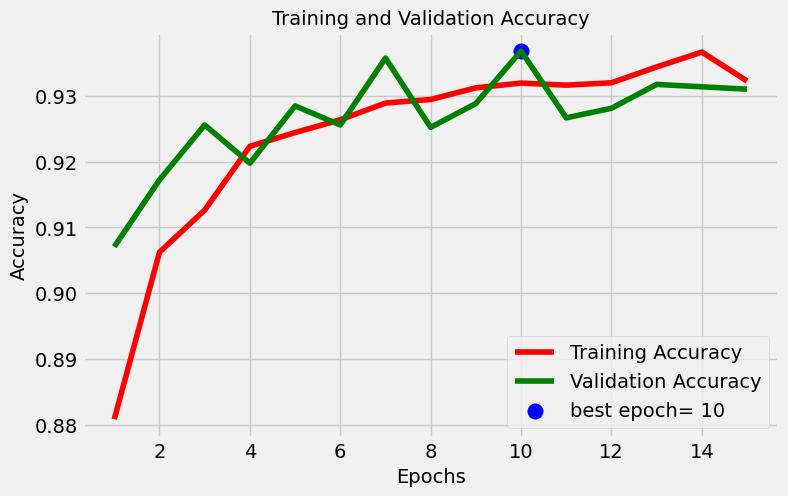

In [32]:
plt.figure(figsize= (8, 5))
plt.plot(epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 120, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend();

In [33]:
test_length = len(test_df)
steps = test_length // TEST_BATCH_SIZE
test_score = model.evaluate(test_gen, steps=steps)

52/52 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9220 - loss: 0.1876


In [34]:
print(f"Test loss: {test_score[0]: .06f}")
print(f"Test accuracy: {round(test_score[1]*100)}%") 

Test loss:  0.200233
Test accuracy: 92%


### Generate confusion matrix and classification report

In [35]:
Yhat = np.argmax(model.predict(test_gen), axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step


In [36]:
Ytrue = test_gen.classes
labels = list(test_gen.class_indices.keys())

#### Confusion matrix

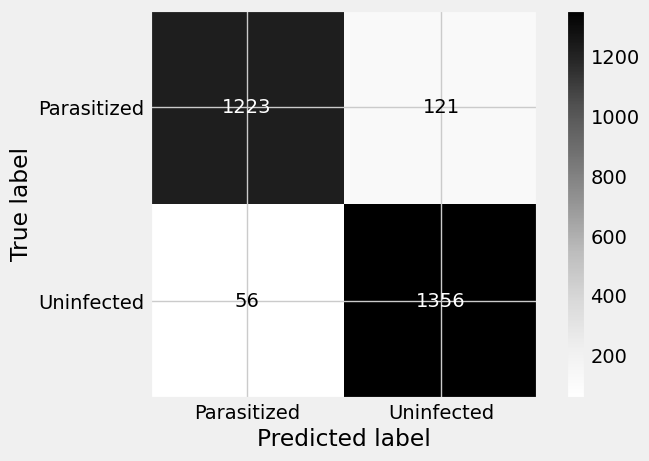

In [37]:
cm = confusion_matrix(y_true=np.array(Ytrue).flatten(), y_pred=Yhat.flatten())
display = ConfusionMatrixDisplay(cm, display_labels=test_gen.class_indices)
display.plot(cmap="Greys");

#### Classification report

In [38]:
print(classification_report(y_true=Ytrue, y_pred=Yhat, target_names=labels))

              precision    recall  f1-score   support

 Parasitized       0.96      0.91      0.93      1344
  Uninfected       0.92      0.96      0.94      1412

    accuracy                           0.94      2756
   macro avg       0.94      0.94      0.94      2756
weighted avg       0.94      0.94      0.94      2756



## Save the model

In [27]:
model.save("malaria_diagnosis_Inception.keras")